# Objective 1.2  -  Quantify associations using regression models.

- Quantify associations between lifestyle, socioeconomic, and healthcare factors and health outcomes (BMI, BP, cholesterol, glucose, chronic disease) using Model based regression

## Step 1: Import and Set Up

***Environment Setup and Library Imports***

I started by importing key libraries for data handling (pandas, numpy), plotting (matplotlib, seaborn), and statistical modeling (statsmodels). I also included tools for working with file paths and regular expressions.

Next, I added the project root folder to Python’s path so I can easily import custom modules from the scripts directory. Then, I imported important folder paths from the project’s configuration and a helper function for formatting paths.

To make data output easier to read, I set pandas to display floats with two decimal places and show all columns when printing dataframes.

With this, the environment is ready for analysis and visualization.

In [1]:
# Setup environment and imports
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np
import re
import matplotlib.gridspec as gridspec


# --- Add project root (parent of 'scripts') to sys.path ---
current_dir = Path().resolve()
project_root = current_dir.parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from scripts.config import (
    FINAL_DATA_DIR,
    SUMMARY_DIR,
    PLOTS_DIR   
)
from scripts.utils import pretty_path, explore_data

# Set pandas float display format for the entire session
pd.options.display.float_format = '{:,.2f}'.format

# Display full columns in pandas
pd.set_option('display.max_columns', None)

print("Setup complete.")


Setup complete.


## STEP 2: Load the complete merged NHANES Dataset

Loading a dataset from a CSV file, making sure the file exists first. Then, I read the data into a dataframe and quickly check what the first few entries look like, along with how many rows and columns it has. It's a simple way to make sure the data loaded correctly and get a quick sense of what's inside.

In [2]:
# Read the csv file into the dataframe

file_path = FINAL_DATA_DIR / "final_merged_nhanes_dataset.csv"
if not file_path.exists():
    raise FileNotFoundError(f"File not found: {pretty_path(file_path)}")
df = pd.read_csv(file_path)

# preview the first few rows of a DataFrame.
df.head()

,participant_id,age,gender,race_ethnicity,education_level,poverty_income_ratio,pir_category,interview_sample_weight,psu,strata,has_health_insurance,sleep_avg_hr,sleep_category,activity_level,total_weekly_min,hei_score,diet_score_category,total_diet_weight,food_item_weight,bmi,obese,systolic_avg,diastolic_avg,bp_category,total_cholesterol,blood_drawn_sample_weight,cholesterol_category,fasting_glucose_mg_dl,fasting_subsample_weight,glucose_category,hypoglycemia_flag,hyperglycemia_flag,log_fasting_glucose_mg_dl,diabetes_dx,diabetes_meds,diabetes_meds_cat,diabetes_status,congestive_heart_failure,coronary_heart_disease,angina,heart_attack,any_cvd,exam_sample_weight
0,130378,43,Male,Non-Hispanic Asian,College graduate or above,5.00,Very High,"50,055.45",2.00,173.00,Yes,9.36,Long Sleep,Low active,135.00,41.57,Poor,"61,366.56","675,032.11",27.00,0.00,132.67,96.00,Hypertension Stage 2,264.00,"56,042.13",High,113.00,"120,025.31",Prediabetes,0.00,0.00,4.73,0.00,NaN,Unknown,0.00,0.00,0.00,0.00,0.00,0,"54,374.46"
1,130379,66,Male,Non-Hispanic White,College graduate or above,5.00,Very High,"29,087.45",2.00,173.00,Yes,9.00,Normal Sleep,Moderately active,180.00,70.28,Needs Improvement,"34,638.06","588,846.96",33.50,1.00,117.00,78.67,Normal,214.00,"37,435.71",Borderline high,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,Unknown,0.00,0.00,0.00,0.00,0.00,0,"34,084.72"
2,130380,44,Female,Other Hispanic,High school/GED,1.41,Mid,"80,062.67",1.00,174.00,Yes,8.29,Normal Sleep,Low active,20.00,56.10,Poor,"84,728.26","1,101,467.40",29.70,0.00,109.00,78.33,Normal,187.00,"85,328.84",Desirable,156.00,"145,090.77",Diabetes,0.00,1.00,5.05,1.00,1.00,Taking meds,1.00,0.00,0.00,0.00,0.00,0,"81,196.28"
3,130386,34,Male,Mexican American,Some college/AA degree,1.33,Mid,"30,995.28",1.00,179.00,Yes,7.64,Normal Sleep,Low active,30.00,36.88,Poor,"82,013.37","738,120.29",30.20,1.00,115.00,73.67,Normal,183.00,"44,526.21",Desirable,100.00,"82,599.62",Prediabetes,0.00,0.00,4.61,0.00,NaN,Unknown,0.00,0.00,0.00,0.00,0.00,0,"39,988.45"
4,130387,68,Female,Non-Hispanic White,College graduate or above,1.32,Mid,"19,896.97",1.00,181.00,Yes,3.57,Short Sleep,NaN,NaN,53.56,Poor,"20,032.62","420,684.93",42.60,1.00,141.33,76.00,Hypertension Stage 2,203.00,"22,746.30",Borderline high,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,Unknown,0.00,0.00,0.00,0.00,0.00,0,"20,776.25"


***Exploring the Final Merged NHANES Dataset***

I began by exploring the final merged NHANES dataset, which brings together all relevant participant information — including demographics, lifestyle behaviors, dietary patterns, and health indicators like BMI.

This step helps verify that the data is clean, complete, and ready for analysis. By reviewing the structure, missing values, and basic distributions, I ensured that the dataset is in good shape for running meaningful models and visualizations.

In [3]:
# Explore and Understand the full merged NHANES Data
print("Exploring final merged NHANES data..")
explore_data(df)

Exploring final merged NHANES data..

--- Exploring Dataset ---
Shape: (6064, 43)

First 5 rows:
   participant_id  age  gender      race_ethnicity            education_level  \
0          130378   43    Male  Non-Hispanic Asian  College graduate or above   
1          130379   66    Male  Non-Hispanic White  College graduate or above   
2          130380   44  Female      Other Hispanic            High school/GED   
3          130386   34    Male    Mexican American     Some college/AA degree   
4          130387   68  Female  Non-Hispanic White  College graduate or above   

   poverty_income_ratio pir_category  interview_sample_weight  psu  strata  \
0                  5.00    Very High                50,055.45 2.00  173.00   
1                  5.00    Very High                29,087.45 2.00  173.00   
2                  1.41          Mid                80,062.67 1.00  174.00   
3                  1.33          Mid                30,995.28 1.00  179.00   
4                  1.32   

## STEP 3: Data analysis and visualization

### 1a. Regression Model - Predicting BMI

***Analyzing How Lifestyle and Socioeconomic Factors Affect BMI***

I prepare the dataset for regression analysis by selecting key variables that could influence BMI, including sleep duration, diet quality (HEI score), physical activity level, education, income(PIR), health insurance status, age, gender, and race/ethnicity. I ensure that all categorical variables are properly encoded for the model.

I then fit a weighted linear regression model, using the survey’s sample weights to account for the complex sampling design. This approach provides more accurate estimates of how lifestyle and socio-economic factors are associated with BMI in the population.

After fitting the model, I print and save a detailed summary of the results. This allows us to interpret which factors significantly contribute to BMI differences, helping to identify potential targets for public health interventions.



In [4]:
model_cols = [
    'bmi', 'sleep_avg_hr', 'activity_level', 'hei_score',
    'education_level', 'poverty_income_ratio',
    'has_health_insurance', 'age', 'gender', 'race_ethnicity',
    'exam_sample_weight' ]

model_df = df[model_cols].copy()

# Drop rows with missing values
model_df.dropna(inplace=True)
print("Final rows for BMI regression model:", model_df.shape[0])

# Create categorical versions for regression

categorical_cols = ['gender', 'education_level', 'activity_level', 'has_health_insurance','race_ethnicity']
for col in categorical_cols:
   model_df[col] = model_df[col].astype('category')

# Define formula 
bmi_formula = "bmi ~ sleep_avg_hr + hei_score + C(activity_level) + poverty_income_ratio + C(education_level) + C(has_health_insurance) + age + C(gender) + C(race_ethnicity)"

# Fit GLM
bmi_model = smf.wls(
    formula=bmi_formula,
    data=model_df,
    weights=model_df["exam_sample_weight"]
).fit(cov_type="HC3")

print(bmi_model.summary())

# Make sure the summary directory exists
SUMMARY_DIR.mkdir(parents=True, exist_ok=True)

summary_txt_path = SUMMARY_DIR / "obj_1.2_bmi_quantify_association_regression_analysis_summary.txt"

with open(summary_txt_path, 'w') as f:
    f.write(bmi_model.summary().as_text())

print(f"BMI Regression quantify association summary saved to {pretty_path(summary_txt_path)}")


Final rows for BMI regression model: 3523
                            WLS Regression Results                            
Dep. Variable:                    bmi   R-squared:                       0.083
Model:                            WLS   Adj. R-squared:                  0.079
Method:                 Least Squares   F-statistic:                     15.69
Date:                Tue, 29 Jul 2025   Prob (F-statistic):           5.94e-45
Time:                        20:44:38   Log-Likelihood:                -12103.
No. Observations:                3523   AIC:                         2.424e+04
Df Residuals:                    3505   BIC:                         2.435e+04
Df Model:                          17                                         
Covariance Type:                  HC3                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------

### 1b. Regression Model -  BMI visualization

***Make Model Variable Names Easy to Read***

I wrote a small piece of code to clean up the messy variable names that come out of the model. For example, instead of showing something like C(gender)[T.Male], it just shows gender Male. This makes the labels easier to read and understand for everyone.

In [5]:
def clean_label(var_name):
    """
    Makes variable names from the model output easier to read.
    
    Examples:
    - 'C(strata)[T.185.0]' → 'strata: 185.0'
    - 'C(education_level)[T.<9th grade]' → 'education_level: <9th grade'
    - 'hei_score' → 'hei_score'
    """

    # Handles variables like C(variable)[T.level]
    if 'C(' in var_name and '[T.' in var_name:
        # Get variable and level names using regex
        match = re.match(r'C\((.*?)\)\[T\.(.*?)\]', var_name)
        if match:
            variable, level = match.groups()
            return f"{variable}: {level}"

    # Handles variables like C(variable) without any level
    elif var_name.startswith('C('):
        return re.sub(r'C\((.*?)\)', r'\1', var_name)

    # Handles cases like "variable[T.level]" 
    elif '[T.' in var_name:
        return var_name.replace('[T.', ': ').replace(']', '')

    return var_name


***Understanding What Affects BMI Using Regression and Visuals***

I used the BMI model we made earlier to see how different habits and personal details affect BMI. First, I cleaned up the model’s results by taking out the intercept (we don’t need it right now) and put the rest into a simple table.
Then, I marked which factors actually matter — the ones that clearly affect BMI based on the data. I sorted everything by how big their effects are, so we can quickly see what has the most impact. Next, I used the model to predict BMI and compared those predictions to the real numbers. I also checked how far off the predictions were (the errors).

To show everything clearly, I made five different charts:

- A chart showing how each factor affects BMI, with lines to show how confident we are.

- A histogram of the errors, to check if the model’s mistakes look random (which is a good sign).

- A plot comparing predicted BMI to actual BMI — the closer the dots are to the line, the better.

- A bar chart showing which factors matter most overall.

- A scatter plot showing the link between sleep and BMI, with a trend line to show the pattern.

Lastly, I saved all the charts as one image to use later it on.

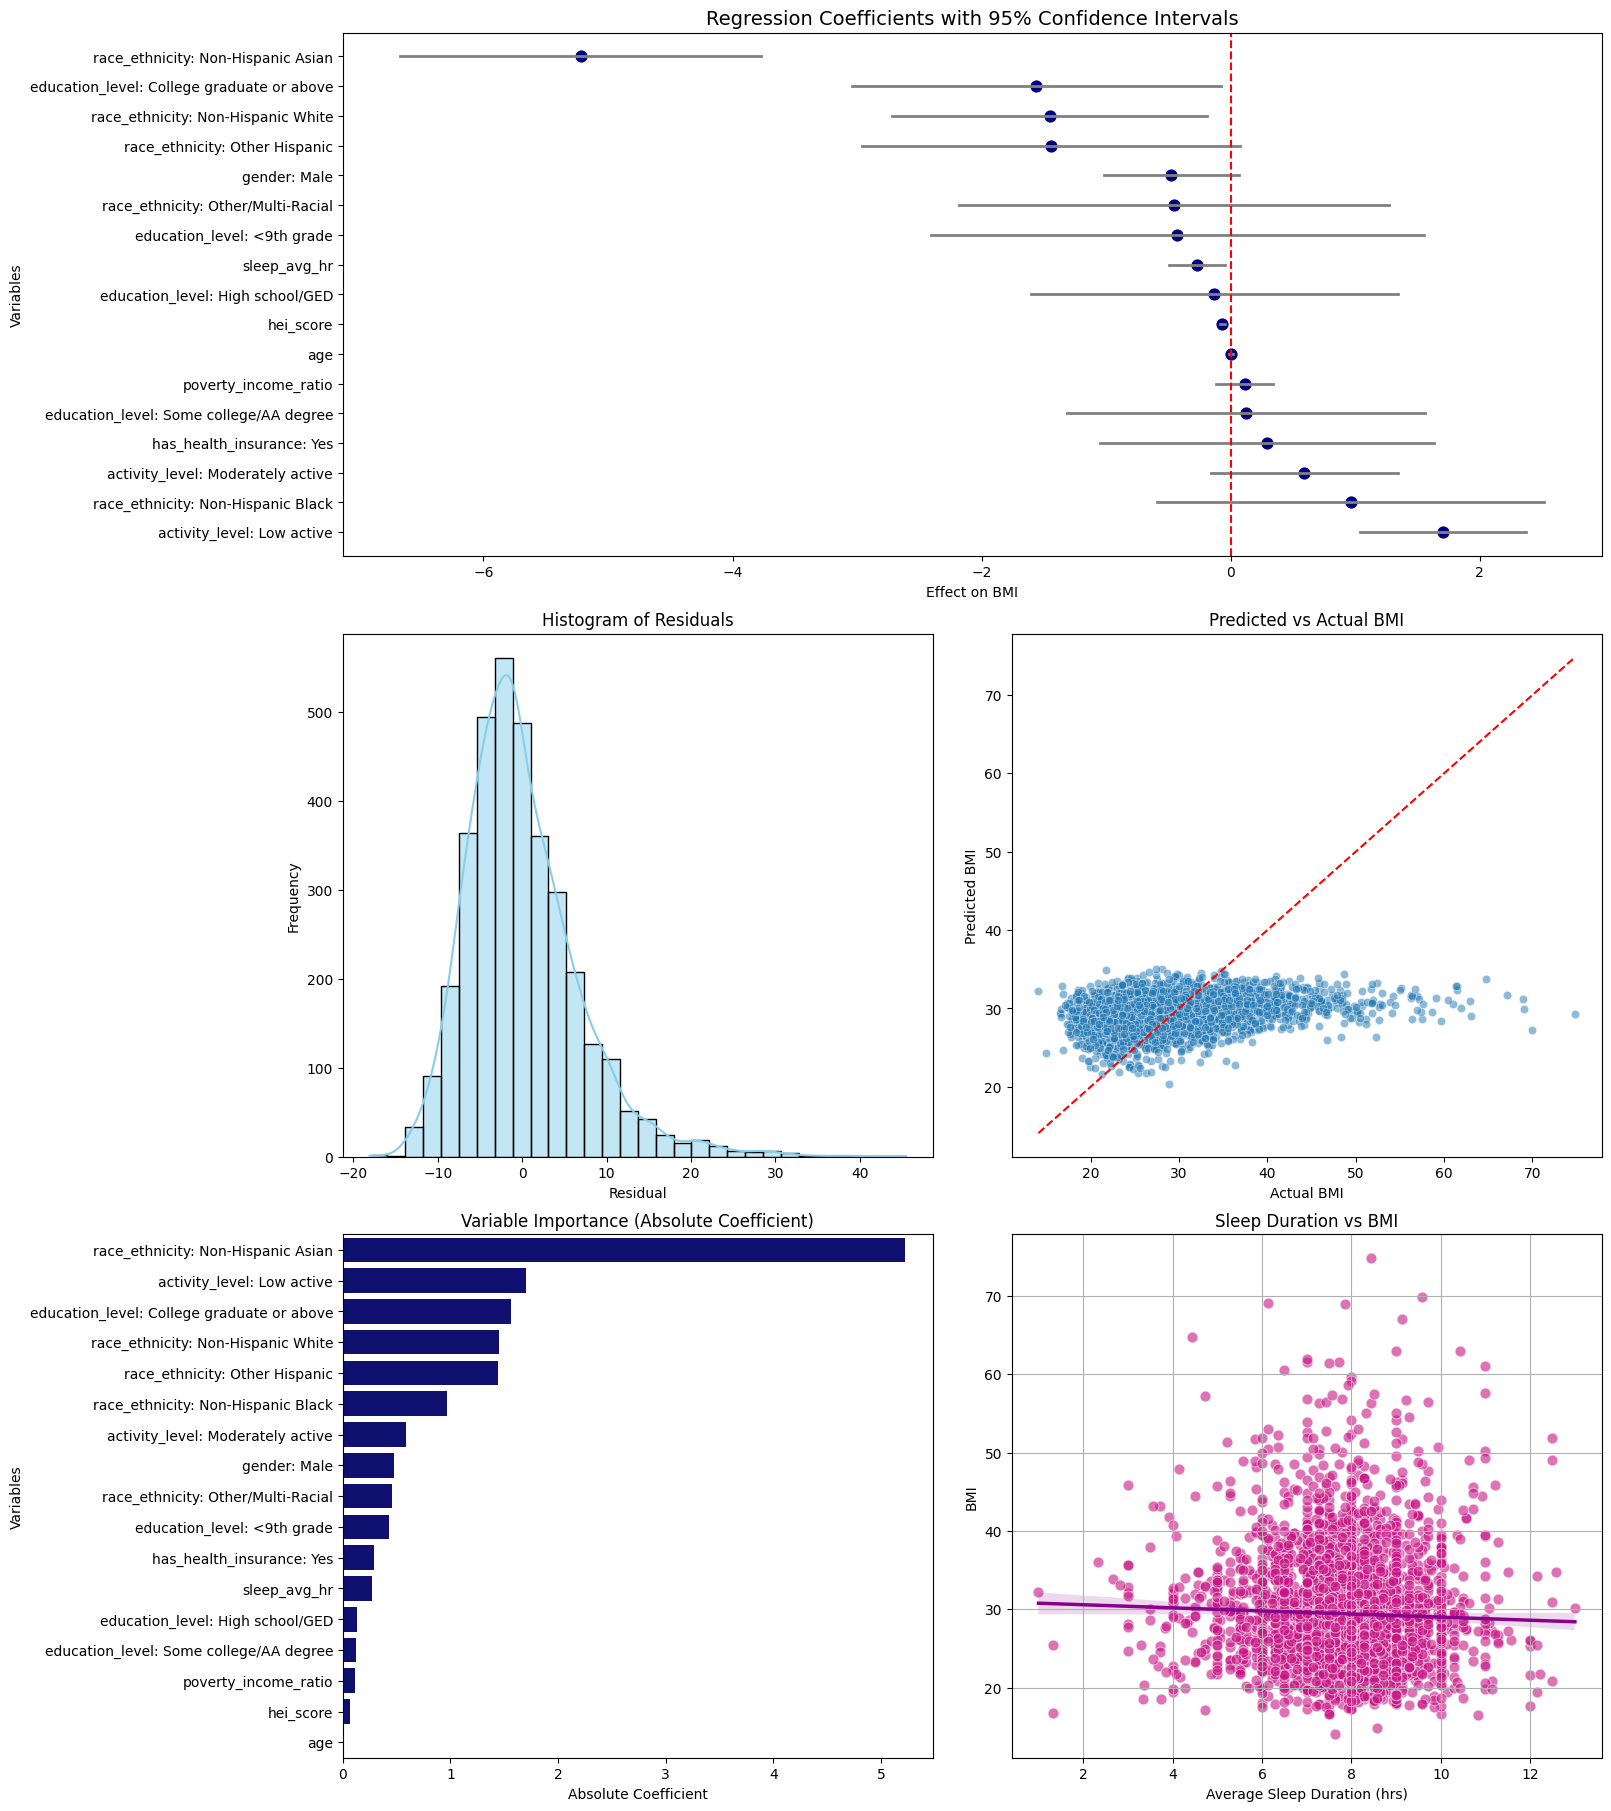


BMI Regression quantify association summary saved to: outputs\plots\obj_1.2_bmi_quantify_association_regression_analysis_plot.png


In [6]:

bmi_results = bmi_model

# Prepare coefficient DataFrame from summary2()
coef_df = bmi_results.summary2().tables[1].reset_index().rename(columns={
    'index': 'Variable',
    'Coef.': 'Coefficient',
    '[0.025': 'CI Lower',
    '0.975]': 'CI Upper',
    'P>|z|': 'pvalue'
})

# Remove Intercept
coef_df = coef_df[coef_df['Variable'] != 'Intercept']

# Mark significance
coef_df['significant'] = coef_df['pvalue'] < 0.05

# Sort by coefficient value for plotting
coef_df_sorted = coef_df.sort_values('Coefficient').reset_index(drop=True)

coef_df_sorted['Clean Variable'] = coef_df_sorted['Variable'].apply(clean_label)

# Extract residuals (response residuals)
residuals = bmi_results.resid

# Predict BMI using the fitted model
model_df = model_df.copy()
model_df['predicted_bmi'] = bmi_results.predict()

# Setup figure and gridspec
fig = plt.figure(constrained_layout=True, figsize=(16, 18))
gs = gridspec.GridSpec(3, 2, figure=fig)

# 1. Coefficients plot (top row, both columns)
ax_coef = fig.add_subplot(gs[0, :])

# 2. Residual histogram (2nd row, left)
ax_resid = fig.add_subplot(gs[1, 0])

# 3. Predicted vs Actual BMI (2nd row, right)
ax_pred = fig.add_subplot(gs[1, 1])

# 4. Variable Importance (3rd row, left)
ax_varimp = fig.add_subplot(gs[2, 0])

# 5. Sleep Duration vs BMI (3rd row, right)
ax_sleep = fig.add_subplot(gs[2, 1])

# ===== Plot 1: Coefficients with Confidence Intervals =====
sns.pointplot(
    x='Coefficient', y='Clean Variable', data=coef_df_sorted,
    color='navy', ax=ax_coef, linestyle='none'
)

for i, row in coef_df_sorted.iterrows():
    ax_coef.plot([row['CI Lower'], row['CI Upper']], [i, i], color='gray', lw=2)
ax_coef.axvline(0, color='red', linestyle='--')
ax_coef.set_title("Regression Coefficients with 95% Confidence Intervals", fontsize=14)
ax_coef.set_xlabel("Effect on BMI")
ax_coef.set_ylabel("Variables")

# ===== Plot 2: Residuals Histogram =====
sns.histplot(residuals, bins=30, kde=True, color='skyblue', ax=ax_resid)
ax_resid.set_title("Histogram of Residuals")
ax_resid.set_xlabel("Residual")
ax_resid.set_ylabel("Frequency")

# ===== Plot 3: Predicted vs Actual BMI =====
sns.scatterplot(x=model_df['bmi'], y=model_df['predicted_bmi'], alpha=0.5, ax=ax_pred)
min_bmi = model_df['bmi'].min()
max_bmi = model_df['bmi'].max()
ax_pred.plot([min_bmi, max_bmi], [min_bmi, max_bmi], '--', color='red')
ax_pred.set_title("Predicted vs Actual BMI")
ax_pred.set_xlabel("Actual BMI")
ax_pred.set_ylabel("Predicted BMI")

# ===== Plot 4: Variable Importance (Absolute Coefficients) =====
coef_df_sorted['abs_coef'] = coef_df_sorted['Coefficient'].abs()
coef_df_sorted_desc = coef_df_sorted.sort_values('abs_coef', ascending=False)
sns.barplot(
    x='abs_coef', y='Clean Variable', data=coef_df_sorted_desc,
    color='navy', ax=ax_varimp
)
ax_varimp.set_title("Variable Importance (Absolute Coefficient)")
ax_varimp.set_xlabel("Absolute Coefficient")
ax_varimp.set_ylabel("Variables")

# ===== Plot 5: Sleep Duration vs BMI with Regression Line =====
sns.scatterplot(x='sleep_avg_hr', y='bmi', data=model_df, alpha=0.6, color='mediumvioletred', s=60, ax=ax_sleep)
sns.regplot(x='sleep_avg_hr', y='bmi', data=model_df, scatter=False, color='darkmagenta', line_kws={'linewidth': 2.5}, ax=ax_sleep)
ax_sleep.set_title("Sleep Duration vs BMI")
ax_sleep.set_xlabel("Average Sleep Duration (hrs)")
ax_sleep.set_ylabel("BMI")
ax_sleep.grid(True)

# Save and show plot
plot_path = PLOTS_DIR / "obj_1.2_bmi_quantify_association_regression_analysis_plot.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"\nBMI Regression quantify association summary saved to: {pretty_path(plot_path)}")


### 2a. Regression Model - BP Analysis

***Modeling Blood Pressure: Effects of Lifestyle and Demographics with Survey Adjustments***

Here I'm working on blood pressure models. First, I pick the important columns—things like systolic and diastolic blood pressure, sleep hours, activity level, diet score, and some demographics. I clean the data by dropping any rows that have missing info. Then, I make sure all the categories like gender, education, and race are treated properly in the model. 
After that, I set up formulas for two models—one for systolic and one for diastolic blood pressure. I run the models using weighted least squares, which helps adjust for the survey weights. Finally, I print the results and save the summaries so they can be looked at later.

In [7]:
model_cols = [
    'systolic_avg', 'diastolic_avg', 'sleep_avg_hr', 'activity_level', 'hei_score',
    'education_level', 'poverty_income_ratio', 'has_health_insurance',
    'age', 'gender', 'race_ethnicity', 'exam_sample_weight']

bp_df = df[model_cols].copy()
bp_df.dropna(inplace=True)
print("Final rows for BP regression model:", bp_df.shape[0])

# Convert categorical columns to category dtype (including strata)
categorical_cols = ['gender', 'education_level', 'activity_level', 'has_health_insurance', 'race_ethnicity']
for col in categorical_cols:
    bp_df[col] = bp_df[col].astype('category')

# Define full model formula 
predictors_formula = (
    'C(gender) + C(education_level) + C(activity_level) + '
    'C(has_health_insurance) + C(race_ethnicity) + '
    'age + sleep_avg_hr + hei_score + poverty_income_ratio'
)

systolic_formula = f'systolic_avg ~ {predictors_formula}'
diastolic_formula = f'diastolic_avg ~ {predictors_formula}'

# Fit WLS models with survey weights and cluster-robust SEs by PSU
systolic_model = smf.wls(
    formula=systolic_formula,
    data=bp_df,
    weights=bp_df["exam_sample_weight"]
).fit(cov_type="HC3")

diastolic_model = smf.wls(
    formula=diastolic_formula,
    data=bp_df,
    weights=bp_df["exam_sample_weight"]
).fit(cov_type="HC3")

print("\nSystolic BP Model:\n", systolic_model.summary())
print("\nDiastolic BP Model:\n", diastolic_model.summary())

# Save summary to text file
summary_txt_path = SUMMARY_DIR / "obj_1.2_bp_model_quantify_association_summary.txt"
with open(summary_txt_path, "w") as f:
    f.write("Systolic BP Model:\n")
    f.write(systolic_model.summary().as_text())
    f.write("\n\nDiastolic BP Model:\n")
    f.write(diastolic_model.summary().as_text())

print(f"BP model summaries saved to {pretty_path(summary_txt_path)}")


Final rows for BP regression model: 3478

Systolic BP Model:
                             WLS Regression Results                            
Dep. Variable:           systolic_avg   R-squared:                       0.205
Model:                            WLS   Adj. R-squared:                  0.201
Method:                 Least Squares   F-statistic:                     43.16
Date:                Tue, 29 Jul 2025   Prob (F-statistic):          9.36e-131
Time:                        20:44:41   Log-Likelihood:                -14620.
No. Observations:                3478   AIC:                         2.928e+04
Df Residuals:                    3460   BIC:                         2.939e+04
Df Model:                          17                                         
Covariance Type:                  HC3                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

### 2b. Regression Model - BP Visualization

***Visualizing Blood Pressure Model Diagnostics and Coefficients***

Added predicted values and residuals for systolic and diastolic blood pressure to the data. Created plots to check model fit by showing residuals against predicted values. Then, visualized the regression coefficients with confidence intervals to understand the impact of each variable. Combined all plots into a single figure and saved it for review.


 bp model diagnostics plot saved to: outputs\plots\obj_1.2_bp_model_diagnostics_combined_plot.png


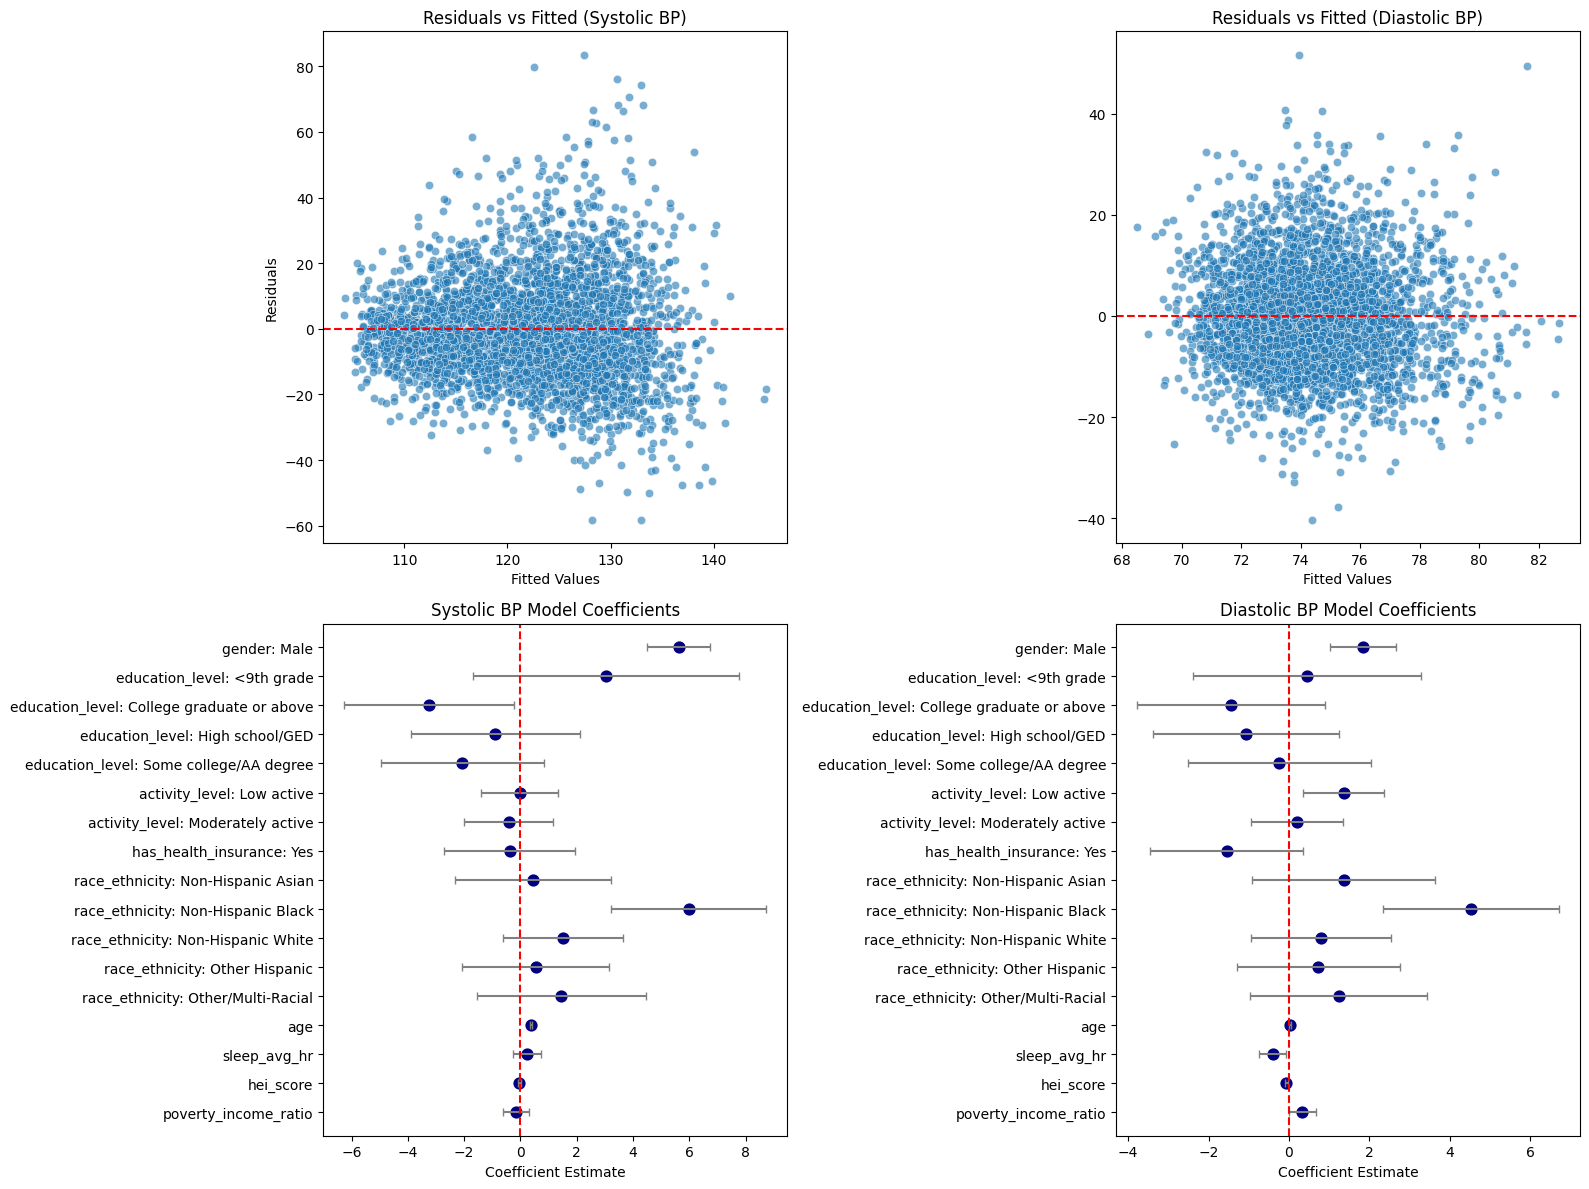

In [8]:
# Add predictions and residuals to the dataframe
bp_df["systolic_pred"] = systolic_model.fittedvalues
bp_df["systolic_resid"] = systolic_model.resid
bp_df["diastolic_pred"] = diastolic_model.fittedvalues
bp_df["diastolic_resid"] = diastolic_model.resid

# Define the coefficient plotting function
def plot_coefficients(model, title, ax):
    coefs = model.params
    errors = model.bse
    conf_int = model.conf_int()
    conf_int.columns = ['ci_low', 'ci_high']

    coef_df = pd.DataFrame({
        'coef': coefs,
        'se': errors,
        'ci_low': conf_int['ci_low'],
        'ci_high': conf_int['ci_high']
    }).reset_index().rename(columns={'index': 'term'})

    coef_df = coef_df[~coef_df['term'].str.contains("Intercept")]

    # Replace or define your clean_label function as needed
    coef_df['term'] = coef_df['term'].apply(clean_label)

    sns.pointplot(
        data=coef_df,
        y="term", x="coef",
        linestyle='none',
        markers='o',
        color='navy',
        ax=ax
    )

    ax.errorbar(
        coef_df["coef"], coef_df["term"],
        xerr=[coef_df["coef"] - coef_df["ci_low"], coef_df["ci_high"] - coef_df["coef"]],
        fmt='none', ecolor='gray', capsize=3
    )
    ax.axvline(0, color='red', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel("Coefficient Estimate")
    ax.set_ylabel("")

# Create 2x2 figure for combined plots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Residuals vs Fitted plots (top row)
sns.scatterplot(x="systolic_pred", y="systolic_resid", data=bp_df, ax=axes[0, 0], alpha=0.6)
axes[0, 0].axhline(0, color='red', linestyle='--')
axes[0, 0].set_title("Residuals vs Fitted (Systolic BP)")
axes[0, 0].set_xlabel("Fitted Values")
axes[0, 0].set_ylabel("Residuals")

sns.scatterplot(x="diastolic_pred", y="diastolic_resid", data=bp_df, ax=axes[0, 1], alpha=0.6)
axes[0, 1].axhline(0, color='red', linestyle='--')
axes[0, 1].set_title("Residuals vs Fitted (Diastolic BP)")
axes[0, 1].set_xlabel("Fitted Values")
axes[0, 1].set_ylabel("")

# Coefficient plots (bottom row)
plot_coefficients(systolic_model, "Systolic BP Model Coefficients", axes[1, 0])
plot_coefficients(diastolic_model, "Diastolic BP Model Coefficients", axes[1, 1])

plt.tight_layout()

# Save the combined plot to file
plot_path = PLOTS_DIR / "obj_1.2_bp_model_diagnostics_combined_plot.png"
plt.savefig(plot_path)
print(f"\n bp model diagnostics plot saved to: {pretty_path(plot_path)}")

plt.show()
plt.close()


### 3a. Regression Model - Total Cholestrol

***Building a Weighted Regression Model to Identify Factors Influencing Total Cholesterol Levels***

I selected the key variables to predict total cholesterol levels and cleaned the data by removing missing values. Then, I turned some variables into categories to use them properly in the model. I built a weighted regression model to understand how factors like sleep duration, diet, activity level, income, education, insurance, age, gender, and race affect total cholesterol. Finally, I saved the full results summary for reference.

In [9]:
import statsmodels.formula.api as smf

# Define model columns
model_cols = [
    'total_cholesterol', 
    'sleep_avg_hr', 'activity_level', 'hei_score',
    'education_level', 'poverty_income_ratio',
    'has_health_insurance', 'age', 'gender', 'race_ethnicity',
    'blood_drawn_sample_weight'
]

# Prepare data
chol_df = df[model_cols].copy()
chol_df.dropna(inplace=True)

print("Final rows for total_cholesterol model:", chol_df.shape[0])

# Convert categorical variables
categorical_cols = ['gender', 'education_level', 'activity_level', 'has_health_insurance', 'race_ethnicity']
for col in categorical_cols:
    chol_df[col] = chol_df[col].astype('category')

# Define regression formula
chol_formula = (
    'total_cholesterol ~ sleep_avg_hr + hei_score + '
    'C(activity_level) + poverty_income_ratio + '
    'C(education_level) + C(has_health_insurance) + age + '
    'C(gender) + C(race_ethnicity)'
)

# Fit weighted least squares with robust SEs
chol_model = smf.wls(
    formula=chol_formula,
    data=chol_df,
    weights=chol_df['blood_drawn_sample_weight']
)
chol_results = chol_model.fit(cov_type="HC3")

# Print summary
print(chol_results.summary())

# Save summary text file
summary_txt_path = SUMMARY_DIR / "obj_1.2_total_cholesterol_quantify_association_regression_summary.txt"
with open(summary_txt_path, 'w') as f:
    f.write(chol_results.summary().as_text())

print(f"Total Cholesterol Regression summary saved to {pretty_path(summary_txt_path)}")


Final rows for total_cholesterol model: 3285
                            WLS Regression Results                            
Dep. Variable:      total_cholesterol   R-squared:                       0.033
Model:                            WLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     4.693
Date:                Tue, 29 Jul 2025   Prob (F-statistic):           5.76e-10
Time:                        20:44:42   Log-Likelihood:                -17191.
No. Observations:                3285   AIC:                         3.442e+04
Df Residuals:                    3267   BIC:                         3.453e+04
Df Model:                          17                                         
Covariance Type:                  HC3                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------

### 3b. Regression Model - Total Cholestrol - Visualization

***Visualizing Cholesterol Model Results: Predictions, Errors, and Key Factors***

I extracted the regression coefficients and confidence intervals from the model results, cleaned up the variable names for easier reading, and sorted them by effect size. Then, I added predicted cholesterol values and residuals to the dataset.

Next, I created a figure with three plots:

- Predicted vs. actual total cholesterol values to check model accuracy.

- Distribution of residuals to assess model errors.

- A coefficient plot showing the size and uncertainty of each predictor’s effect.

Finally, I saved the plot and displayed it.

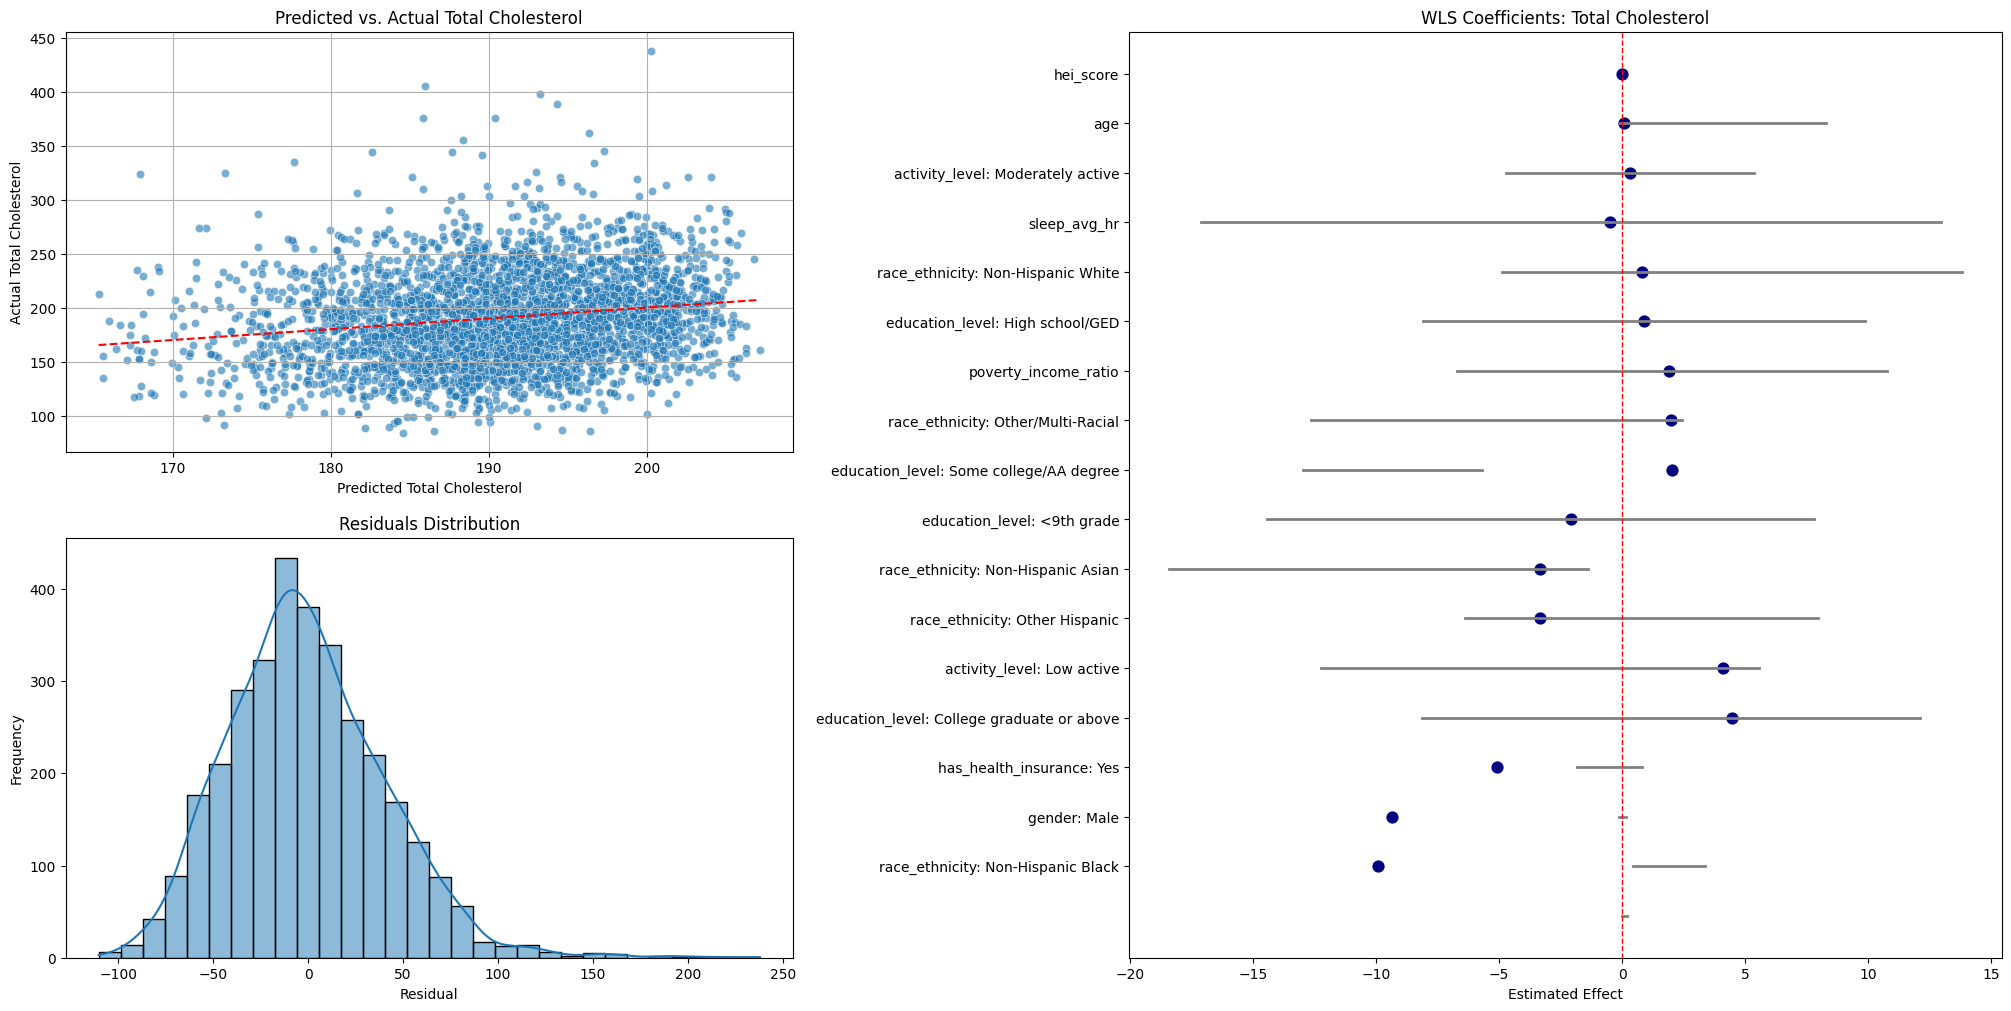


Total cholesterol quantify association plots saved to: outputs\plots\obj_1.2_total_cholesterol_quantify_association_plot.png


In [10]:
# Extract coefficients table and clean it
coef_df = chol_results.summary2().tables[1].copy()
coef_df = coef_df.reset_index().rename(columns={'index': 'Variable'})
coef_df = coef_df.rename(columns={"Coef.": "Coefficient", "[0.025": "CI Lower", "0.975]": "CI Upper"})
coef_df = coef_df[coef_df['Variable'] != 'Intercept']

# Apply clean_label function to create clean variable names
coef_df['Clean Variable'] = coef_df['Variable'].apply(clean_label)
coef_df['abs_coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=True)

# Add predicted values and residuals to chol_df
chol_df['predicted_chol'] = chol_results.fittedvalues
chol_df['residuals'] = chol_results.resid

# Plot layout
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1.2])

# Plot 1: Predicted vs Actual
ax0 = fig.add_subplot(gs[0, 0])
sns.scatterplot(x='predicted_chol', y='total_cholesterol', data=chol_df, alpha=0.6, ax=ax0)
ax0.plot([chol_df['predicted_chol'].min(), chol_df['predicted_chol'].max()],
         [chol_df['predicted_chol'].min(), chol_df['predicted_chol'].max()],
         color='red', linestyle='--')
ax0.set_title('Predicted vs. Actual Total Cholesterol')
ax0.set_xlabel('Predicted Total Cholesterol')
ax0.set_ylabel('Actual Total Cholesterol')
ax0.grid(True)

# Plot 2: Residuals distribution
ax1 = fig.add_subplot(gs[1, 0])
sns.histplot(chol_df['residuals'], kde=True, bins=30, ax=ax1)
ax1.set_title('Residuals Distribution')
ax1.set_xlabel('Residual')
ax1.set_ylabel('Frequency')

# Plot 3: Coefficients with CIs
ax2 = fig.add_subplot(gs[:, 1])
sns.pointplot(data=coef_df, x="Coefficient", y="Clean Variable", color='navy', markers='o', linestyles='none', ax=ax2)
for i, row in coef_df.iterrows():
    ax2.plot([row['CI Lower'], row['CI Upper']], [i, i], color='gray', lw=2)
ax2.axvline(x=0, linestyle='--', color='red', linewidth=1)
ax2.set_title("WLS Coefficients: Total Cholesterol")
ax2.set_xlabel("Estimated Effect")
ax2.set_ylabel("")

# Save and show plot
plot_path = PLOTS_DIR / "obj_1.2_total_cholesterol_quantify_association_plot.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"\nTotal cholesterol quantify association plots saved to: {pretty_path(plot_path)}")

### 4a. Regression Model - Fasting glucose

***Fasting Glucose Regression Model Setup and Summary***

Selected important columns for the fasting glucose analysis and cleaned the data by removing missing values. Converted key variables to categorical types, including strata, to account for fixed effects. Built a weighted least squares regression model to study how lifestyle and demographic factors relate to fasting glucose levels, using survey weights and robust standard errors. Printed and saved the model summary for further review.

In [11]:
# Columns needed for fasting glucose model 
model_cols = [
    'fasting_glucose_mg_dl',    
    'sleep_avg_hr', 'activity_level', 'hei_score',
    'education_level', 'poverty_income_ratio',
    'has_health_insurance', 'age', 'gender', 'race_ethnicity',
    'fasting_subsample_weight'
]

# Create DataFrame and drop missing values
gluc_df = df[model_cols].copy()
gluc_df.dropna(inplace=True)
print("Final rows for fasting_glucose model:", gluc_df.shape[0])

# Convert categorical variables including strata
categorical_cols = ['gender', 'education_level', 'activity_level', 'has_health_insurance', 'race_ethnicity']
for col in categorical_cols:
    gluc_df[col] = gluc_df[col].astype('category')

# Define regression formula
gluc_formula = (
    'fasting_glucose_mg_dl ~ sleep_avg_hr + hei_score + '
    'C(activity_level) + poverty_income_ratio + C(education_level) + '
    'C(has_health_insurance) + age + C(gender) + C(race_ethnicity)'
)

# Fit weighted least squares regression model with HC3 robust standard errors
gluc_model = smf.wls(
    formula=gluc_formula,
    data=gluc_df,
    weights=gluc_df['fasting_subsample_weight']
)
gluc_results = gluc_model.fit(cov_type="HC3")

# Print summary
print(gluc_results.summary())

# Save summary text to file
summary_txt_path = SUMMARY_DIR / "obj_1.2_fasting_glucose_quantify_association_regression_summary.txt"
with open(summary_txt_path, 'w') as f:
    f.write(gluc_results.summary().as_text())

print(f"Saved fasting glucose quantify association model summary to {pretty_path(summary_txt_path)}")


Final rows for fasting_glucose model: 1830
                              WLS Regression Results                             
Dep. Variable:     fasting_glucose_mg_dl   R-squared:                       0.103
Model:                               WLS   Adj. R-squared:                  0.094
Method:                    Least Squares   F-statistic:                     10.30
Date:                   Tue, 29 Jul 2025   Prob (F-statistic):           7.79e-27
Time:                           20:44:44   Log-Likelihood:                -9131.7
No. Observations:                   1830   AIC:                         1.830e+04
Df Residuals:                       1812   BIC:                         1.840e+04
Df Model:                             17                                         
Covariance Type:                     HC3                                         
                                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------

### 4b. Regression Model - Fasting glucose - Visualization

***Fasting Glucose Model Results and Visualization***

I cleaned up the regression results by organizing the coefficients into a clear table and gave the variable names simpler labels for easier understanding. I sorted the variables by the strength of their effect. Then, I added the model’s predicted fasting glucose values and residuals (the differences between actual and predicted) back to the dataset.

Next, I created a figure with three plots:

- A scatter plot comparing predicted fasting glucose to actual values to see how well the model fits.

- A histogram showing the distribution of residuals to check if errors are spread out randomly.

- A coefficient plot with confidence intervals, showing how each variable influences fasting glucose and how certain we are about those effects.

Finally, I saved the figure so it can be used later in reports.

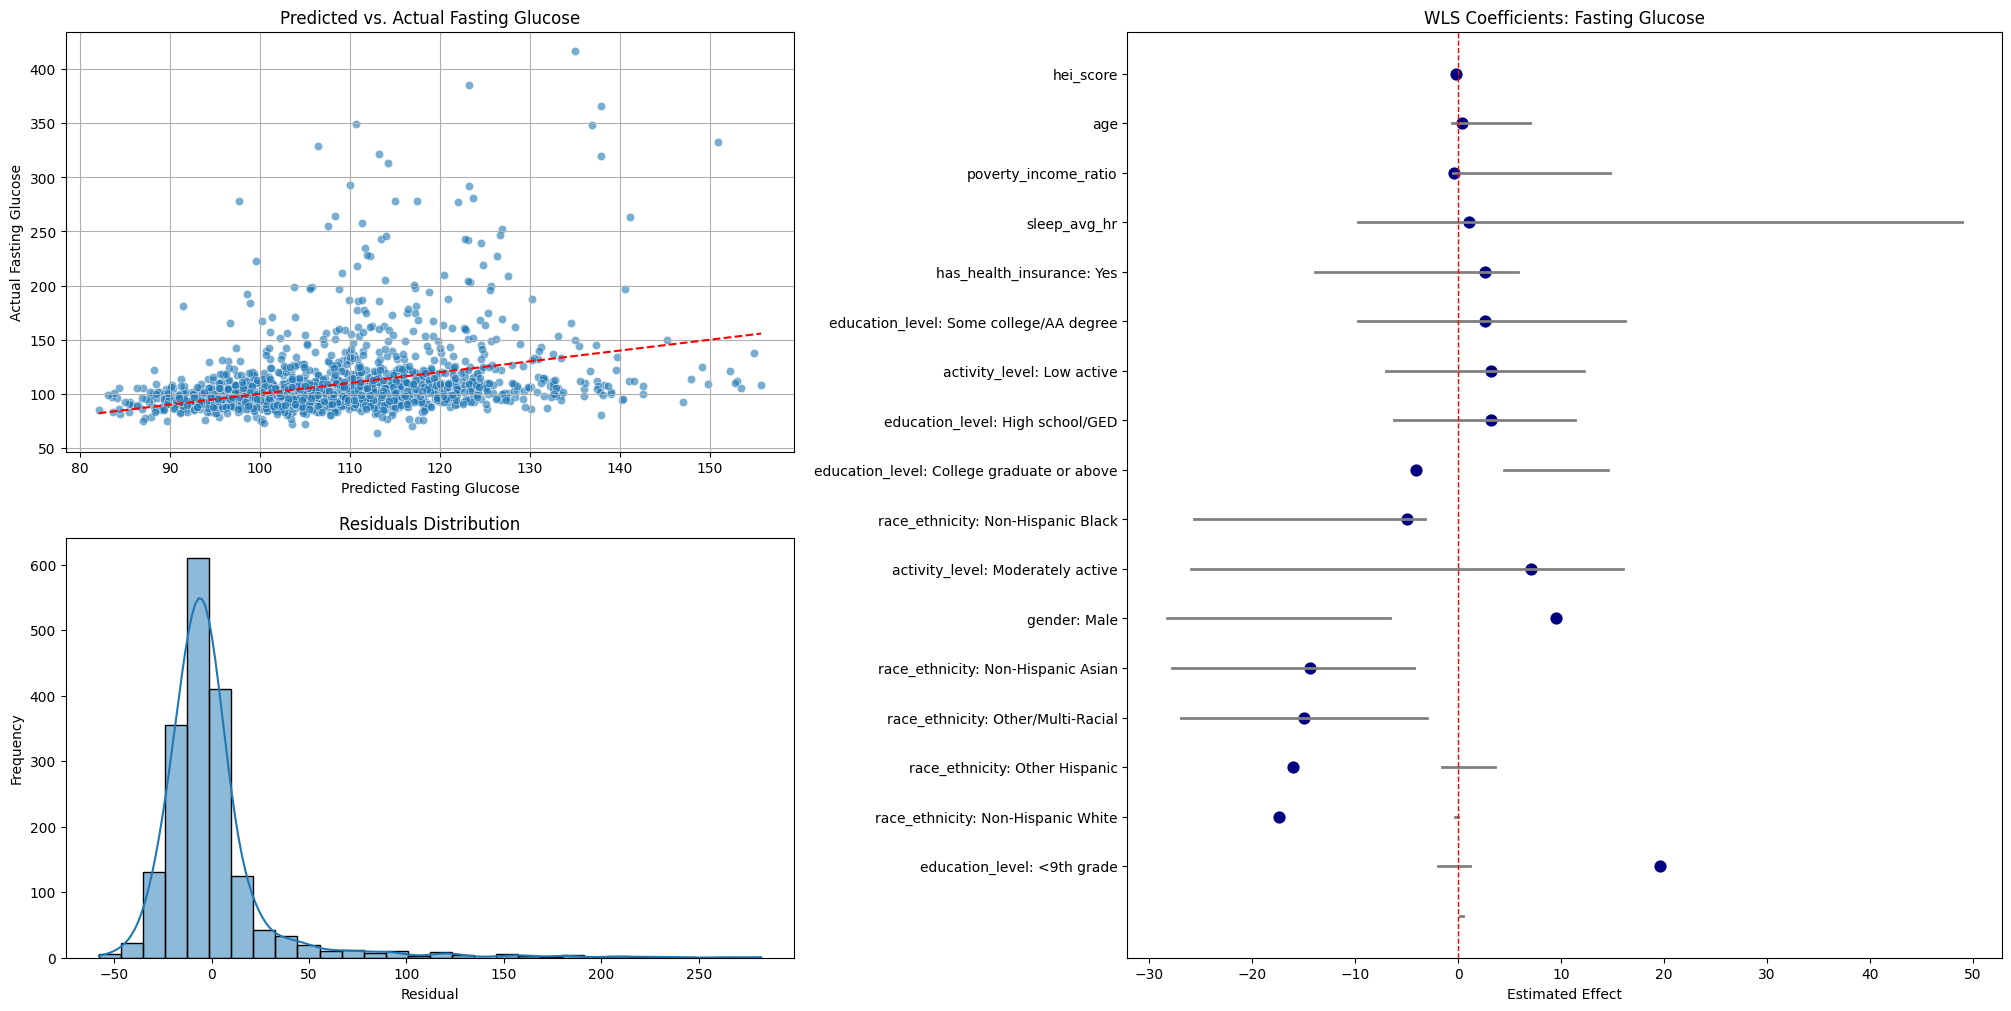


Fasting glucose quantify association plots saved to: outputs\plots\obj_1.2_fasting_glucose_quantify_association_plot.png


In [12]:
# Extract coefficients table and clean it
gluc_coef_df = gluc_results.summary2().tables[1].copy()
gluc_coef_df = gluc_coef_df.reset_index().rename(columns={'index': 'Variable'})
gluc_coef_df = gluc_coef_df.rename(columns={"Coef.": "Coefficient", "[0.025": "CI Lower", "0.975]": "CI Upper"})
gluc_coef_df = gluc_coef_df[gluc_coef_df['Variable'] != 'Intercept']

# Apply clean_label function to create clean variable names
gluc_coef_df['Clean Variable'] = gluc_coef_df['Variable'].apply(clean_label)
gluc_coef_df['abs_coef'] = gluc_coef_df['Coefficient'].abs()
gluc_coef_df = gluc_coef_df.sort_values('abs_coef', ascending=True)

# Add predicted values and residuals to gluc_df
gluc_df['predicted_glucose'] = gluc_results.fittedvalues
gluc_df['residuals'] = gluc_results.resid

# Plot layout
fig = plt.figure(constrained_layout=True, figsize=(20, 10))
gs = fig.add_gridspec(2, 2, width_ratios=[1, 1.2])

# Plot 1: Predicted vs Actual
ax0 = fig.add_subplot(gs[0, 0])
sns.scatterplot(x='predicted_glucose', y='fasting_glucose_mg_dl', data=gluc_df, alpha=0.6, ax=ax0)
ax0.plot([gluc_df['predicted_glucose'].min(), gluc_df['predicted_glucose'].max()],
         [gluc_df['predicted_glucose'].min(), gluc_df['predicted_glucose'].max()],
         color='red', linestyle='--')
ax0.set_title('Predicted vs. Actual Fasting Glucose')
ax0.set_xlabel('Predicted Fasting Glucose')
ax0.set_ylabel('Actual Fasting Glucose')
ax0.grid(True)

# Plot 2: Residuals distribution
ax1 = fig.add_subplot(gs[1, 0])
sns.histplot(gluc_df['residuals'], kde=True, bins=30, ax=ax1)
ax1.set_title('Residuals Distribution')
ax1.set_xlabel('Residual')
ax1.set_ylabel('Frequency')

# Plot 3: Coefficients with CIs
ax2 = fig.add_subplot(gs[:, 1])
sns.pointplot(data=gluc_coef_df, x="Coefficient", y="Clean Variable", color='navy', markers='o', linestyles='none', ax=ax2)
for i, row in gluc_coef_df.iterrows():
    ax2.plot([row['CI Lower'], row['CI Upper']], [i, i], color='gray', lw=2)
ax2.axvline(x=0, linestyle='--', color='red', linewidth=1)
ax2.set_title("WLS Coefficients: Fasting Glucose")
ax2.set_xlabel("Estimated Effect")
ax2.set_ylabel("")

# Save and show plot
plot_path = PLOTS_DIR / "obj_1.2_fasting_glucose_quantify_association_plot.png"
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
plt.show()
plt.close()

print(f"\nFasting glucose quantify association plots saved to: {pretty_path(plot_path)}")


### 5a. Quantify association Regression Model Analysis - Diabetes 

***Weighted Logistic Regression to Identify Factors Linked to Diabetes***

I selected important columns related to diabetes and removed any rows with missing data. Then, I changed some columns to categorical types and identified their baseline categories (reference groups), which I saved for documentation.

Next, I set up a logistic regression formula including lifestyle, demographic, and economic factors to predict diabetes diagnosis. I ran the weighted logistic regression model using survey sample weights and robust standard errors.

Finally, I printed the model summary and saved it as a text file for future use.

In [13]:

# 1. Select Relevant Columns
diabetes_model_cols = [
    'diabetes_dx',              
    'sleep_avg_hr',             
    'hei_score',               
    'activity_level',           
    'education_level',          
    'poverty_income_ratio',     
    'has_health_insurance',    
    'age',                      
    'gender',                   
    'race_ethnicity',              
    'interview_sample_weight'        
]

diabetes_df = df[diabetes_model_cols].copy()

# 2. Clean and Encode
# Drop missing values
diabetes_df.dropna(inplace=True)

# Convert to categorical
categorical_cols = ['gender', 'education_level', 'activity_level', 'has_health_insurance', 'race_ethnicity']
for col in categorical_cols:
    diabetes_df[col] = diabetes_df[col].astype('category')

# Print baseline categories for categorical variables (reference groups)
baseline_df = pd.DataFrame({
    'Categorical Variable': categorical_cols,
    'Baseline Category': [diabetes_df[col].cat.categories[0] for col in categorical_cols]
})

print("\nBaseline Categories (Reference Groups) for Categorical Variables in diabetes:")
print(baseline_df)

# Save baseline info for documentation
baseline_df.to_csv(SUMMARY_DIR / 'obj_1.2_baseline_categories_diabetes.csv', index=False)

# 3. Define Regression Formula
diabetes_formula = """
diabetes_dx ~ sleep_avg_hr + hei_score + C(activity_level) + poverty_income_ratio
+ C(education_level) + C(has_health_insurance) + age + C(gender) + C(race_ethnicity)
"""

# Fit weighted logistic regression (GLM Binomial)
glm_model = sm.GLM.from_formula(
    formula=diabetes_formula,
    data=diabetes_df,
    family=sm.families.Binomial(),
    freq_weights=diabetes_df['interview_sample_weight']
)

diabetes_results = glm_model.fit(cov_type='HC3')  

print(diabetes_results.summary())

# Save summary 
summary_txt_path = SUMMARY_DIR / "obj_1.2_diabetes_quantify_association_regression_summary.txt"
with open(summary_txt_path, 'w') as f:
    f.write(diabetes_results.summary().as_text())

print(f"Diabetes quantify association regression summary saved to:\n   {pretty_path(summary_txt_path)}")



Baseline Categories (Reference Groups) for Categorical Variables in diabetes:
   Categorical Variable Baseline Category
0                gender            Female
1       education_level      9-11th grade
2        activity_level     Highly active
3  has_health_insurance                No
4        race_ethnicity  Mexican American
                 Generalized Linear Model Regression Results                  
Dep. Variable:            diabetes_dx   No. Observations:                 3426
Model:                            GLM   Df Residuals:             108035789.96
Model Family:                Binomial   Df Model:                           17
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.0986e+07
Date:                Tue, 29 Jul 2025   Deviance:                   6.1973e+07
Time:                        20:44:46   Pearson chi2:                 9.37e+07
No. Iterations:                     7

### 5b. Quantify association Regression Model Visualization - Diabetes 

***Diabetes Risk Factors: Odds Ratios from Logistic Regression***

I took the results from the diabetes logistic regression model and calculated odds ratios to understand how each factor affects diabetes risk. Then, I cleaned up the variable names to make them easier to read and added notes showing which category was used as the reference for categorical variables.

Next, I sorted the factors by their odds ratios and labeled them as either increasing or decreasing diabetes risk.

Finally, I created a bar plot showing these odds ratios on a log scale, with colors indicating whether the factor raises or lowers risk. The plot also includes reference lines and labels for clarity. I saved the plot so it can be used in reports or presentations.

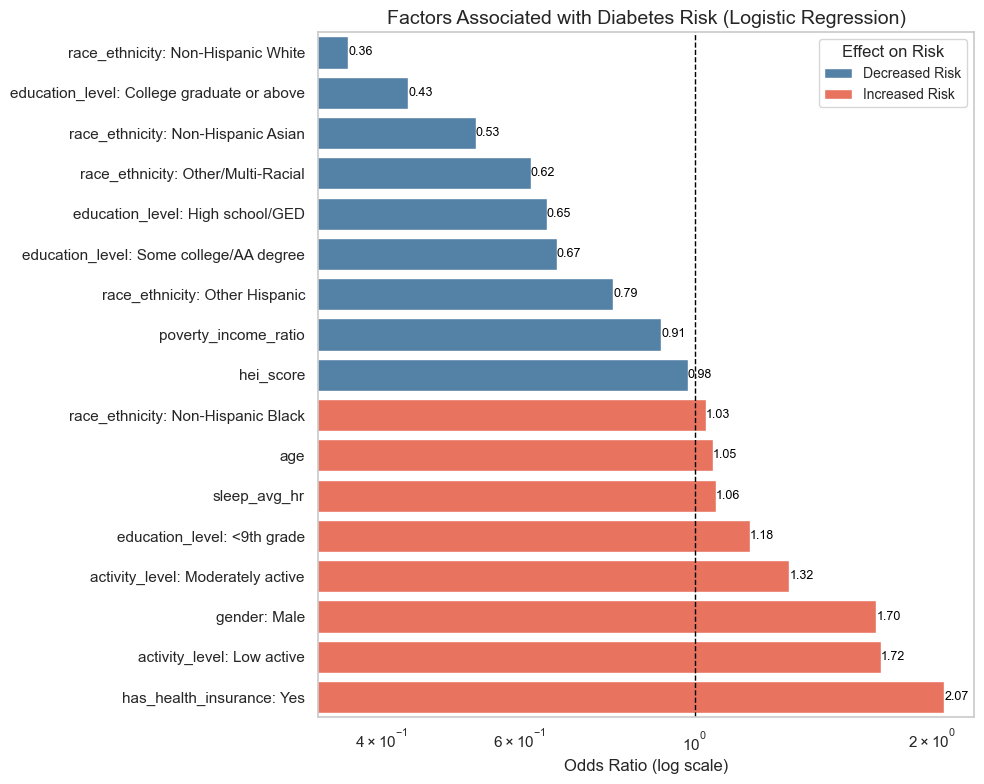

Diabetes quantify association regression plot saved to:
   outputs\plots\obj_1.2_diabetes_odds_ratios_plot.png


In [14]:
# Reference categories dictionary
reference_categories = {
    'gender': 'Female',
    'education_level': '9-11th grade',
    'activity_level': 'Highly active',
    'has_health_insurance': 'No',
    'race_ethnicity': 'Mexican American'
}

def add_reference_label(cleaned_var_name):
    for base_var, ref in reference_categories.items():
        if cleaned_var_name.startswith(f"{base_var} = "):
            return f"{cleaned_var_name} (ref: {ref})"
    return cleaned_var_name

# --- Extract Odds Ratios and Confidence Intervals ---

params = diabetes_results.params
conf = diabetes_results.conf_int()
odds_ratios = np.exp(params)
conf_int_exp = np.exp(conf)

or_df = pd.DataFrame({
    'variable': params.index,
    'odds_ratio': odds_ratios,
    'ci_lower': conf_int_exp[0],
    'ci_upper': conf_int_exp[1]
})

# Remove intercept if present
or_df = or_df[or_df['variable'] != 'Intercept']

# Clean variable names with your function
or_df['variable'] = or_df['variable'].apply(clean_label)

# Add reference labels for categorical variables
or_df['variable'] = or_df['variable'].apply(add_reference_label)

# Sort for nicer plotting (ascending odds ratio as original)
or_df = or_df.sort_values('odds_ratio', ascending=True).reset_index(drop=True)

# Classify effect direction
or_df['Effect'] = or_df['odds_ratio'].apply(lambda x: 'Increased Risk' if x > 1 else 'Decreased Risk')

# Plot Odds Ratios
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

palette = {'Increased Risk': 'tomato', 'Decreased Risk': 'steelblue'}

ax = sns.barplot(
    data=or_df,
    x='odds_ratio',
    y='variable',
    hue='Effect',
    dodge=False,
    palette=palette
)

# Add OR text labels at the end of each bar
for i, row in or_df.iterrows():
    ax.text(
        row['odds_ratio'],               
        i,                              
        f"{row['odds_ratio']:.2f}",     
        color='black',
        va='center',
        ha='left',                      
        fontsize=9
    )

plt.axvline(1, color='black', linestyle='--', linewidth=1)
plt.xlabel('Odds Ratio (log scale)', fontsize=12)
plt.ylabel('')
plt.title('Factors Associated with Diabetes Risk (Logistic Regression)', fontsize=14)
plt.xscale('log')
plt.legend(title='Effect on Risk', loc='upper right', frameon=True, fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the plot
plot_path = PLOTS_DIR / "obj_1.2_diabetes_odds_ratios_plot.png"
plt.savefig(plot_path, dpi=300)
plt.show()
plt.close()
print(f"Diabetes quantify association regression plot saved to:\n   {pretty_path(plot_path)}")


### 6a. Quantify Association Regression Model for Cardiovascular Disease

***Weighted Logistic Regression for Cardiovascular Disease Risk Factors***

I selected key variables related to cardiovascular disease (CVD) and removed any rows with missing values. Then, I converted specified variables to categorical type and identified their baseline (reference) categories, which I saved for documentation.

Next, I defined a logistic regression model with these predictors to estimate the odds of having CVD. I ran the model using survey weights and robust standard errors to account for the study design and variability.

Finally, I printed the model results summary and saved it as a text file for reporting.

In [15]:
# Parameters
target = 'any_cvd'
predictors = [
    'age', 'gender', 'race_ethnicity', 'education_level', 'pir_category',
    'sleep_category', 'activity_level', 'diet_score_category', 'obese',
    'bp_category', 'cholesterol_category', 'glucose_category'
]
categorical_vars = [
    'gender', 'race_ethnicity', 'education_level', 'pir_category',
    'sleep_category', 'activity_level', 'diet_score_category',
    'bp_category', 'cholesterol_category', 'glucose_category'
]

# Preprocessing
df_cvd = df.copy()
df_cvd = df_cvd.dropna(subset=[target] + predictors)

# Convert categorical variables to category dtype
for col in categorical_vars:
    df_cvd[col] = df_cvd[col].astype('category')

# Print baseline categories for categorical variables (reference groups)
baseline_df = pd.DataFrame({
    'Categorical Variable': categorical_vars,
    'Baseline Category': [df_cvd[col].cat.categories[0] for col in categorical_vars]
})

print("\nBaseline Categories (Reference Groups) for Categorical Variables in Cardiovascular Disease model:")
print(baseline_df)

# Save baseline info for documentation
baseline_df.to_csv(SUMMARY_DIR / 'obj_1.2_baseline_categories_cardio_vascular.csv', index=False)

# Define regression formula
formula = f"{target} ~ " + " + ".join(predictors)

# Fit weighted logistic regression (GLM Binomial) with robust covariance
model = smf.glm(
    formula=formula,
    data=df_cvd,
    family=sm.families.Binomial(),
    freq_weights=df_cvd['interview_sample_weight']
)

cardio_results = model.fit(cov_type='HC3')

print(cardio_results.summary())

# Save summary
summary_txt_path = SUMMARY_DIR / "obj_1.2_cardio_vascular_quantify_association_regression_summary.txt"
with open(summary_txt_path, 'w') as f:
    f.write(cardio_results.summary().as_text())

print(f"Cardiovascular disease Regression summary saved to:\n {pretty_path(summary_txt_path)}")



Baseline Categories (Reference Groups) for Categorical Variables in Cardiovascular Disease model:
   Categorical Variable Baseline Category
0                gender            Female
1        race_ethnicity  Mexican American
2       education_level      9-11th grade
3          pir_category              High
4        sleep_category        Long Sleep
5        activity_level     Highly active
6   diet_score_category              Good
7           bp_category          Elevated
8  cholesterol_category   Borderline high
9      glucose_category          Diabetes
                 Generalized Linear Model Regression Results                  
Dep. Variable:                any_cvd   No. Observations:                 1727
Model:                            GLM   Df Residuals:              54059321.11
Model Family:                Binomial   Df Model:                           29
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-

### 6b. Quantify Association Regression Model Visualization for Cardiovascular Disease

***Factors Associated with Cardiovascular Disease Risk: Odds Ratios from a Weighted Logistic Regression***

In this analysis, I looked at what factors are most strongly associated with cardiovascular disease risk. I used a weighted logistic regression model, adjusting for a range of demographic, lifestyle, and clinical variables.

Each variable’s effect is shown in terms of odds ratios. Values above 1 indicate increased risk, while values below 1 suggest a reduced risk—always relative to a specific reference group for each category.

The odds ratios are visualized on a log scale to clearly show the direction and magnitude of each effect. This helps identify which groups may be at higher or lower risk based on these combined factors.

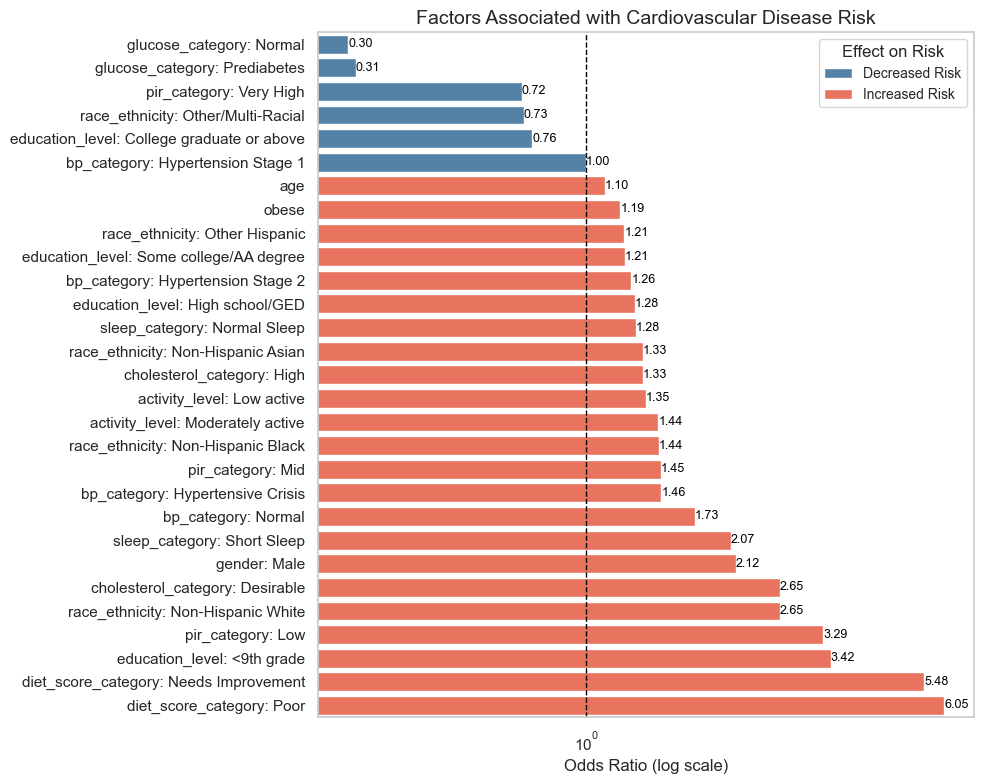

Cardiovascular disease odds ratios plot saved to:
   outputs\plots\obj_1.2_cardio_vascular_odds_ratios_plot.png


In [16]:

# Reference categories dictionary for your cardiovascular disease model
reference_categories_cvd = {
    'gender': 'Female',
    'race_ethnicity': 'Mexican American',
    'education_level': '9-11th grade',
    'pir_category': 'High',
    'sleep_category': 'Long Sleep',
    'activity_level': 'Highly active',
    'diet_score_category': 'Good',
    'bp_category': 'Elevated',
    'cholesterol_category': 'Borderline high',
    'glucose_category': 'Diabetes'
}

def add_reference_label(var_name):
    # var_name example: "gender=Male", "race_ethnicity=Non-Hispanic White"
    for base_var, ref in reference_categories_cvd.items():
        if var_name.startswith(base_var + '='):
            category = var_name.split('=')[1]
            return f"{base_var} = {category} (ref: {ref})"
    return var_name


# Compute Odds Ratios
params = cardio_results.params
conf = cardio_results.conf_int()
odds_ratios = np.exp(params)
conf_int_exp = np.exp(conf)

or_df = pd.DataFrame({
    'variable': params.index,
    'odds_ratio': odds_ratios,
    'ci_lower': conf_int_exp[0],
    'ci_upper': conf_int_exp[1]
})

# Remove intercept/constant terms
or_df = or_df[~or_df['variable'].isin(['Intercept', 'const'])]

# Clean variable names
or_df['variable'] = or_df['variable'].apply(clean_label)

# Add reference labels
or_df['variable'] = or_df['variable'].apply(add_reference_label)

# Sort ascending odds ratio
or_df = or_df.sort_values('odds_ratio').reset_index(drop=True)

# Classify effect direction
or_df['Effect'] = or_df['odds_ratio'].apply(lambda x: 'Increased Risk' if x > 1 else 'Decreased Risk')

# Plotting
sns.set(style="whitegrid")
plt.figure(figsize=(10, 8))

palette = {'Increased Risk': 'tomato', 'Decreased Risk': 'steelblue'}

ax = sns.barplot(
    data=or_df,
    x='odds_ratio',
    y='variable',
    hue='Effect',
    dodge=False,
    palette=palette
)

# Add OR text labels on bars
for i, row in or_df.iterrows():
    ax.text(
        row['odds_ratio'], i,
        f"{row['odds_ratio']:.2f}",
        color='black',
        va='center',
        ha='left',
        fontsize=9
    )

plt.axvline(1, color='black', linestyle='--', linewidth=1)
plt.xlabel('Odds Ratio (log scale)', fontsize=12)
plt.ylabel('')
plt.title('Factors Associated with Cardiovascular Disease Risk', fontsize=14)
plt.xscale('log')
plt.legend(title='Effect on Risk', loc='upper right', frameon=True, fontsize=10)

plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

# Save the plot
plot_path = PLOTS_DIR / "obj_1.2_cardio_vascular_odds_ratios_plot.png"
plt.savefig(plot_path, dpi=300)
plt.show()
plt.close()

print(f"Cardiovascular disease odds ratios plot saved to:\n   {pretty_path(plot_path)}")


***NOTES:***

NHANES collects health data by dividing people into groups to make sure the results represent the whole U.S. population fairly. These groups are called strata and PSUs. Also, each person has a sample weight, which tells us how much they should count when we look at the big picture.

At first, I tried to include these groups (the strata) in my analysis to be more accurate. But it caused problems because the groups were too closely linked to other things in the data, making the analysis unstable. So instead, I left out the groups and used the sample weights along with a special method that helps make the results more reliable even without including all the group information.

Since NHANES only has two main big groups (PSUs), I couldn’t fully account for those either. So, it’s important to remember this when you’re looking at the results.